In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import exp
import os, time, copy

# FORMATANDO BLOWING
- Definindo os critérios de "inicio" e "fim" de sopro manualmente, isso foi feito individualmente em cada arquivo usando o critério de derivada para isso, mas a ideia é o modelo servir de modo geral

In [2]:
def isBlowing(start, end):
    global is_blowing

    if start:
        is_blowing = True

    if end:
        is_blowing = False

    return is_blowing


fileNum  = 13
filePath = f'test_{fileNum}.csv'
df = pd.read_csv(filePath)
df.head()

,time,pressure,mean
0,0.0,33.45240,33.45240
1,0.1,34.50554,33.50506
2,0.2,35.35130,33.60001
3,0.3,36.01184,33.72798
4,0.4,36.50970,33.88084


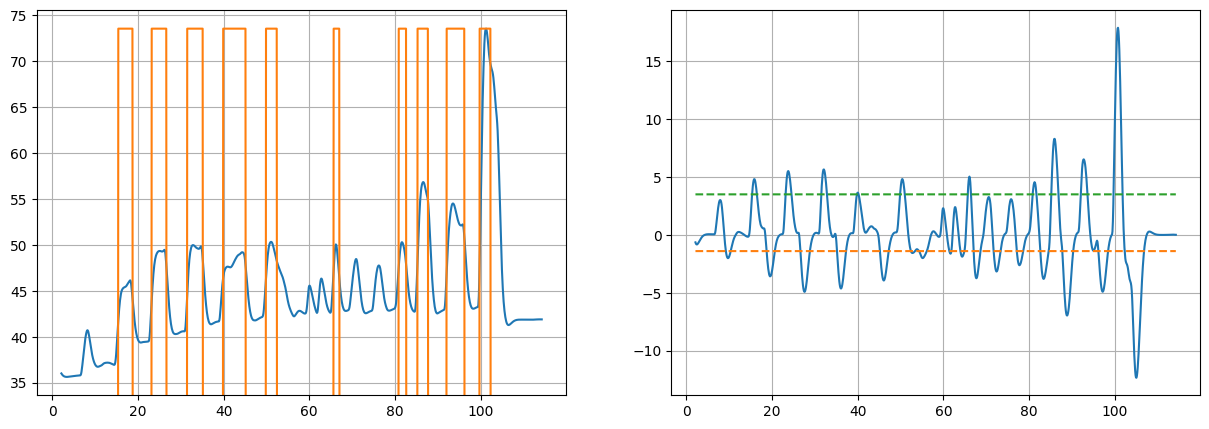

In [6]:
df = df.loc[df.time > 2.0]
is_blowing   = False
lower, upper = (-1.4, 3.5)

df['ratio'] = df['pressure'] - df['mean']
df['start_blow'] = df.ratio > upper
df['stop_blow']  = df.ratio < lower
df['blowing']    = df.apply(lambda row: isBlowing(row.start_blow, row.stop_blow), axis=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.blowing*df.pressure.max())
plt.ylim(df.pressure.min()-2, df.pressure.max()+2), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.ratio)
plt.plot(df.time, lower * np.ones_like(df.time), '--')
plt.plot(df.time, upper * np.ones_like(df.time), '--')
plt.grid()
df.to_csv(filePath, index=None)

# VERIFICANDO TABELAS

In [7]:
files = [file for file in os.listdir(None) if '.csv' in file]
print(files)

['test_1.csv', 'test_10.csv', 'test_11.csv', 'test_12.csv', 'test_13.csv', 'test_2.csv', 'test_3.csv', 'test_4.csv', 'test_5.csv', 'test_6.csv', 'test_7.csv', 'test_8.csv', 'test_9.csv']


14
15
16
17
18
19
20
21
22
23
24
25
26


In [27]:
def getTables(files):
    tables = {}

    for filePath in files:
        tables[filePath] = pd.read_csv(filePath)

    return tables


tables = getTables(files)
tables[files[0]]

,time,pressure,mean,ratio,start_blow,stop_blow,blowing
0,2.1,40.10467,40.12988,-0.02521,False,False,False
1,2.2,40.10160,40.12774,-0.02614,False,False,False
2,2.3,40.09878,40.12553,-0.02675,False,False,False
3,2.4,40.09624,40.12325,-0.02701,False,False,False
4,2.5,40.09407,40.12092,-0.02685,False,False,False
...,...,...,...,...,...,...,...
540,56.1,52.16488,53.39425,-1.22937,False,True,False
541,56.2,52.08163,53.30609,-1.22446,False,True,False
542,56.3,52.00801,53.20163,-1.19362,False,True,False
543,56.4,51.94256,53.08652,-1.14396,False,True,False


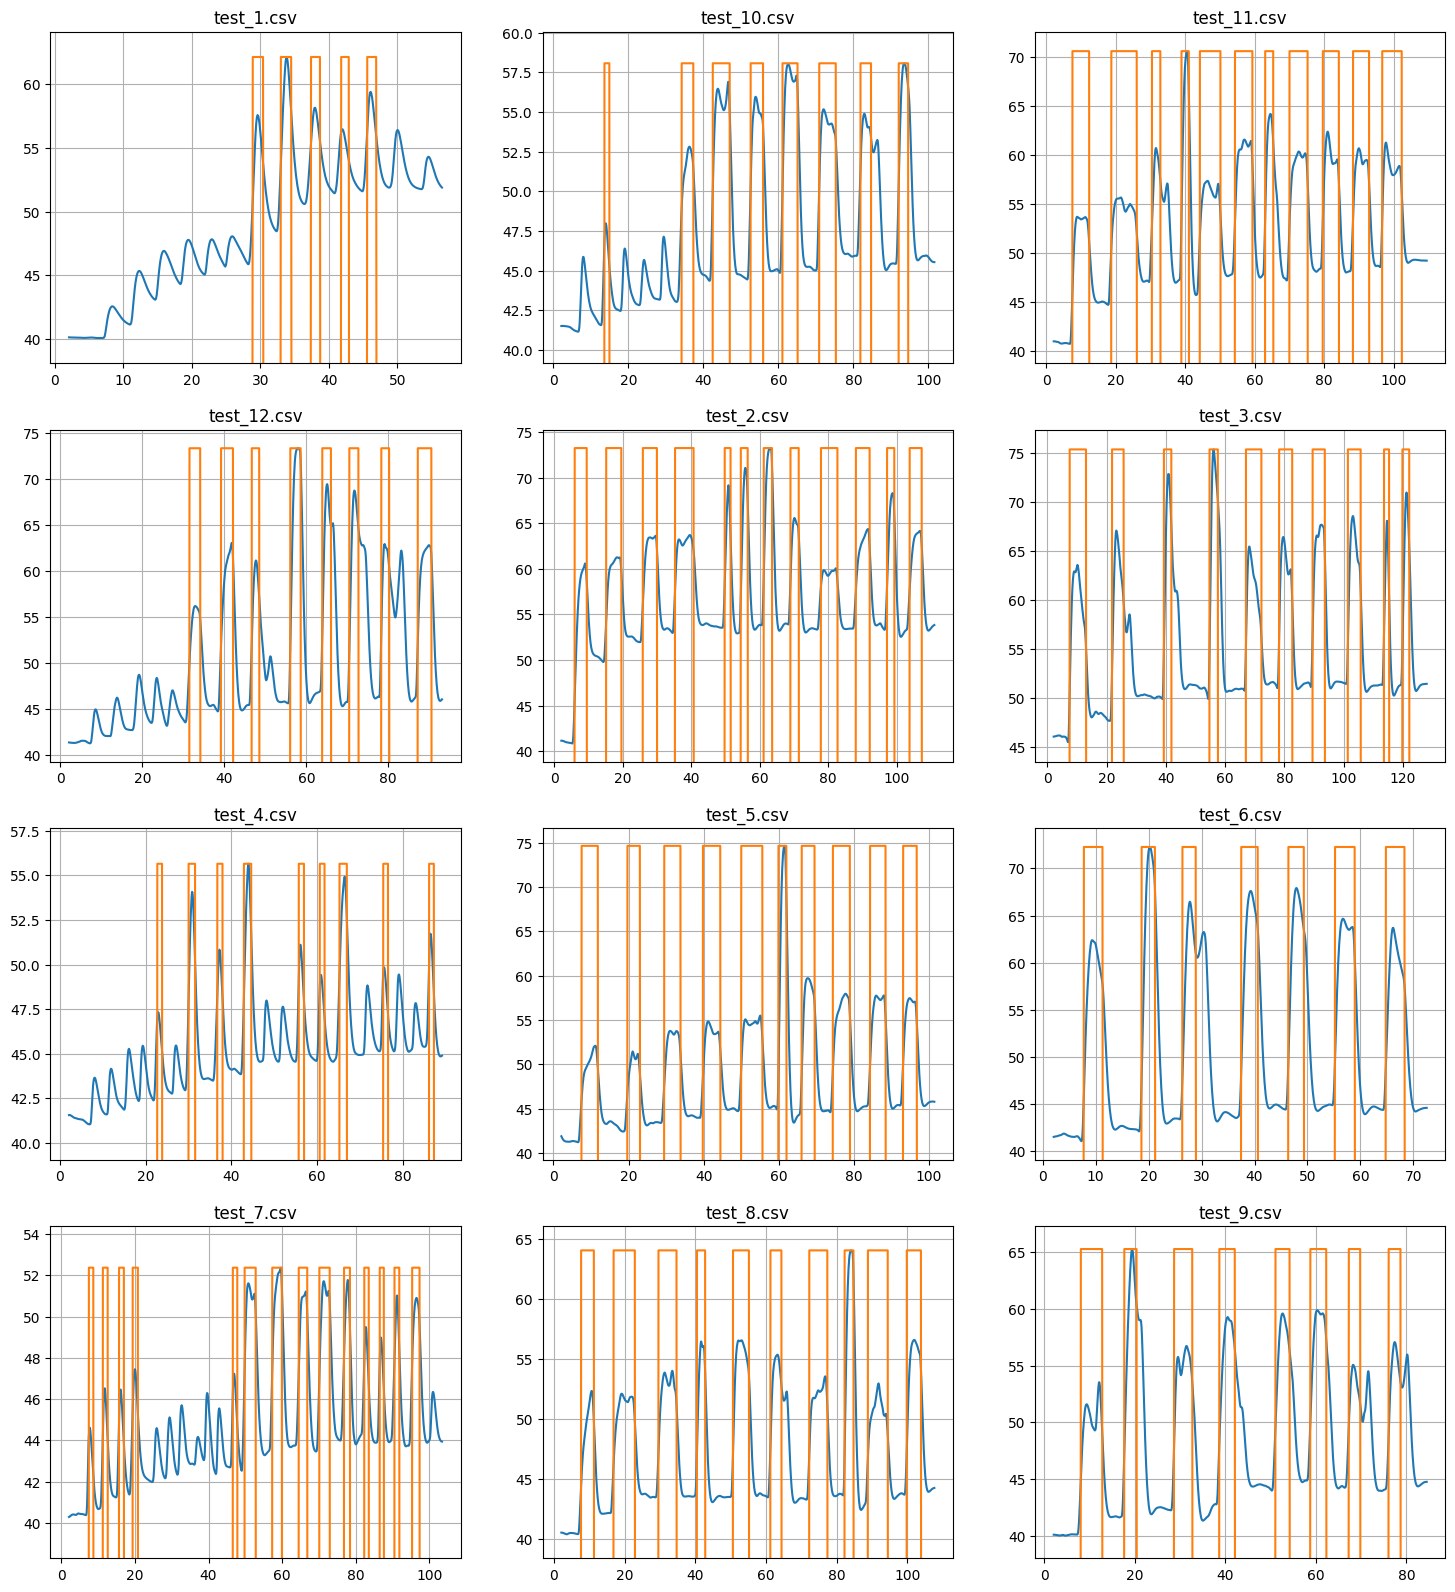

In [28]:
def plotTables(tables):
    numRows = len(tables.values()) // 3 + 1
    plt.figure(figsize=(18, 5*numRows))

    for i, name in enumerate(tables.keys()):
        table = tables[name]
        plt.subplot(numRows, 3, i+1)
        plt.plot(table.time, table.pressure)
        plt.plot(table.time, table.blowing*table.pressure.max())
        plt.ylim(table.pressure.min()-2, table.pressure.max()+2)
        plt.grid(), plt.title(name)
    
    plt.show()


plotTables(tables)

# JUNTANDO TABELAS
- Todos os arquivos agora serão juntados em 1 só, para isso, o tempo terá que iniciar (ser somado) partir do último valor do arquivo anterior (para ficar contínuo)

size: 11343


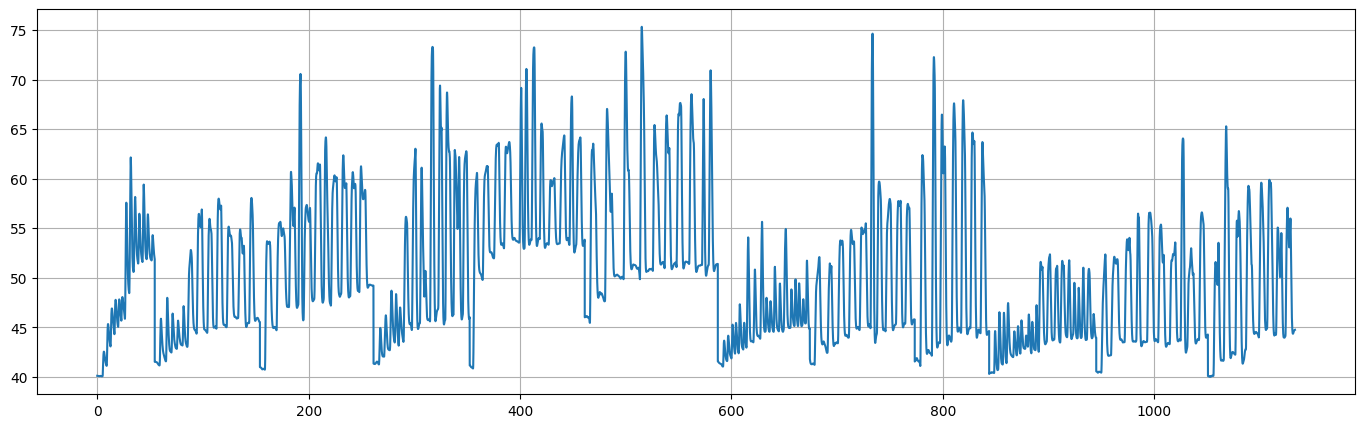

In [29]:
def joinTables(tables):
    df = pd.DataFrame()

    for table in tables.values():
        table['time'] = table.time - table.time.values[0]
        t0 = 0 if len(df) == 0 else df.time.values[-1]

        table['time'] = table.time + t0
        df = pd.concat([df, table])

    return df


df = joinTables(tables)
print('size:', len(df))
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.grid()

In [30]:
def getChance(percentage=30):
    return np.random.rand() < (percentage / 100)

getChance(60)

True

test_1.csv (modo 2): m = 1.00 | s = 258.35
test_10.csv (modo 1): m = 0.96 | s = 5.75
test_11.csv (modo 2): m = 1.07 | s = 117.98
test_12.csv (modo 0): m = 0.89 | s = -16.37
test_2.csv (modo 1): m = 0.99 | s = 1.05
test_3.csv (modo 2): m = 0.98 | s = 86.47
test_4.csv (modo 2): m = 1.05 | s = 40.55
test_5.csv (modo 0): m = 1.03 | s = -8.73
test_6.csv (modo 2): m = 1.10 | s = 226.95
test_7.csv (modo 0): m = 0.80 | s = -19.63
test_8.csv (modo 2): m = 0.81 | s = 44.74
test_9.csv (modo 2): m = 0.79 | s = 354.73


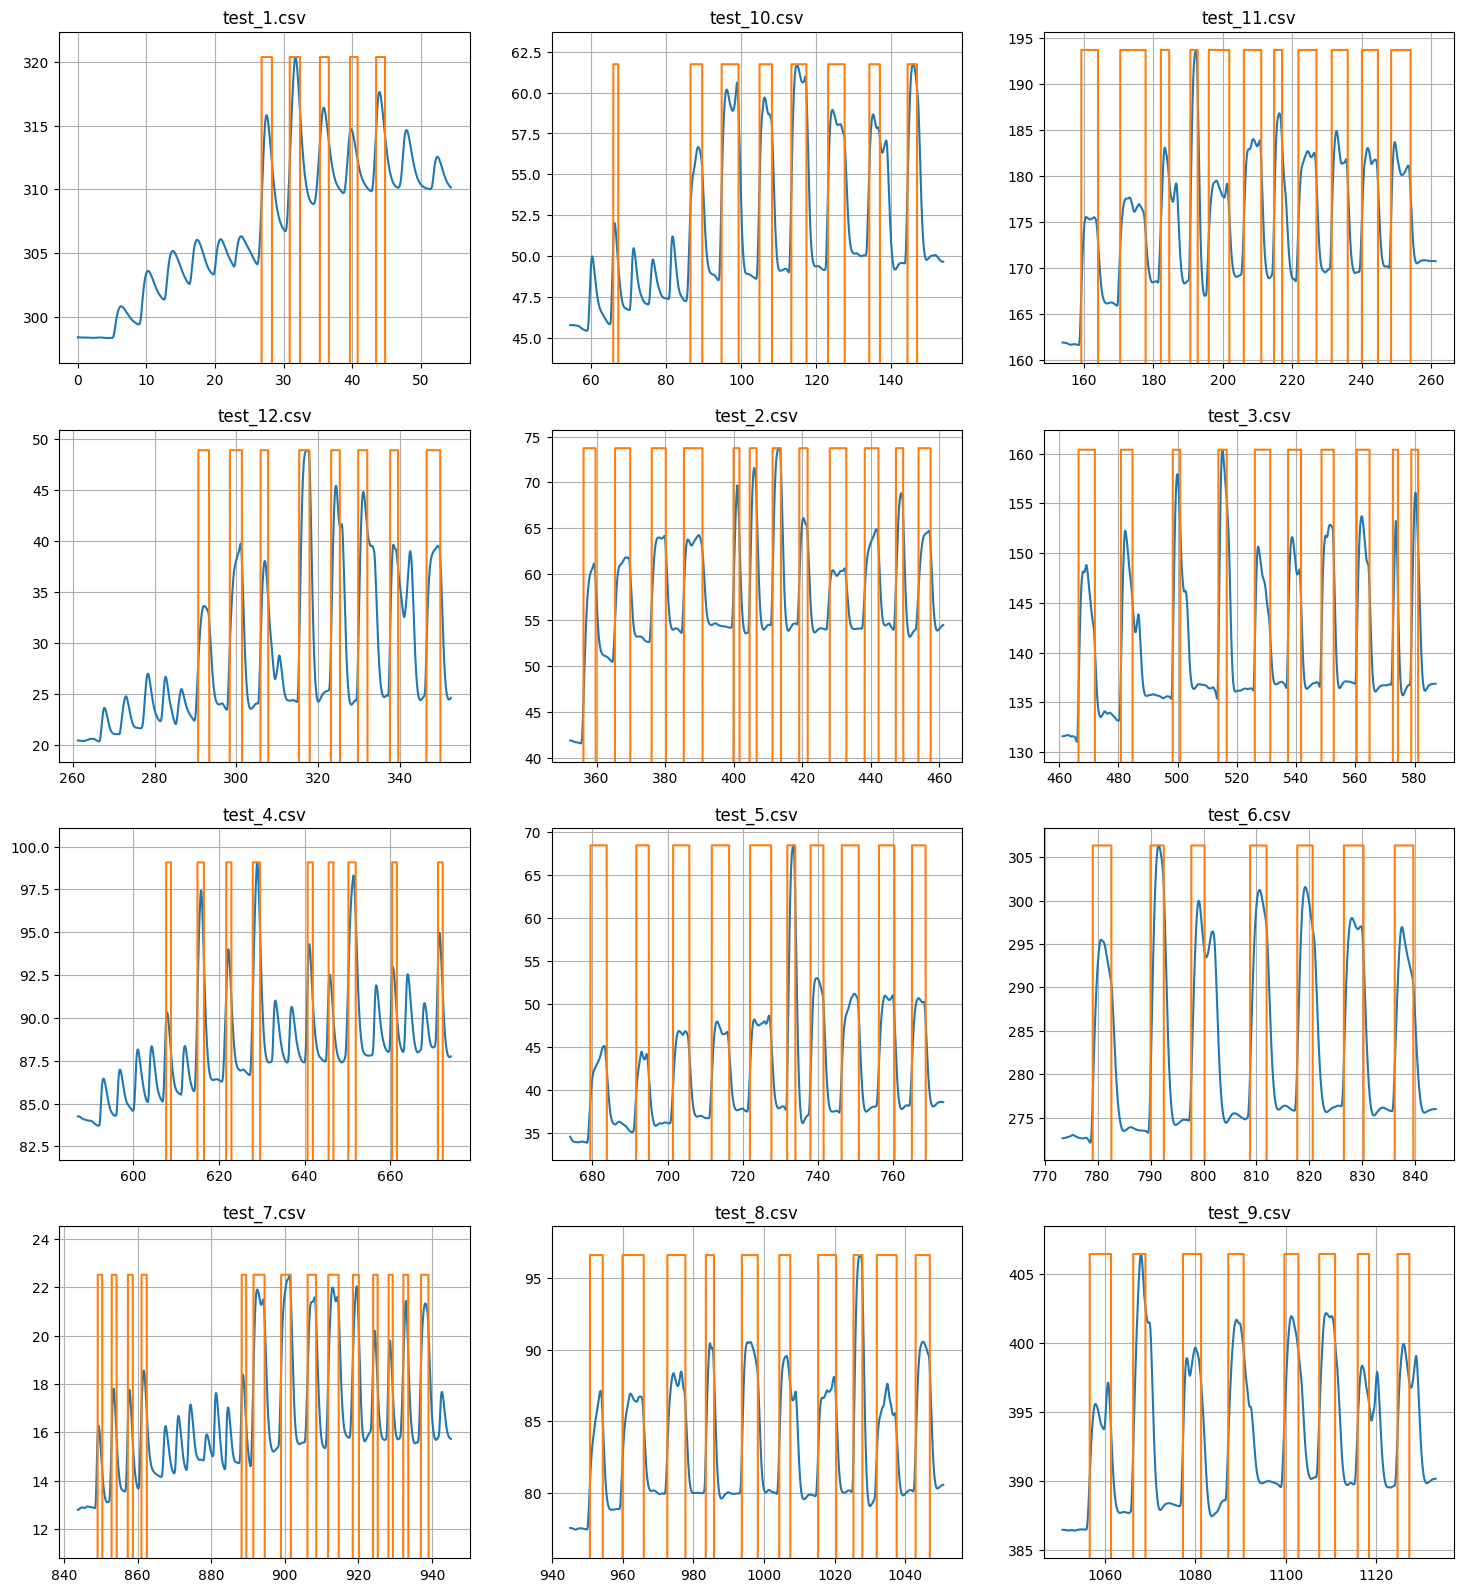

In [31]:
def normalizeTables(df):
    dataset = copy.deepcopy(df)

    for name, table in dataset.items():
        if getChance(25):
            mode = 0
            multiplyer = np.random.uniform(0.75, 1.15)
            somador = np.random.uniform(-35, 0)
        elif getChance(35):
            mode = 1
            multiplyer = np.random.uniform(0.95, 1.05)
            somador = np.random.uniform(-10, 10)
        else:
            mode = 2
            multiplyer = np.random.uniform(0.75, 1.15)
            somador = np.random.uniform(0, 370)
        
        print(f'{name} (modo {mode}): m = {multiplyer:.2f} | s = {somador:.2f}')
        table['pressure'] = (table['pressure'] * multiplyer) + somador
        table['mean']     = (table['mean'] * multiplyer) + somador

    return dataset


normalized = normalizeTables(tables)
plotTables(normalized)

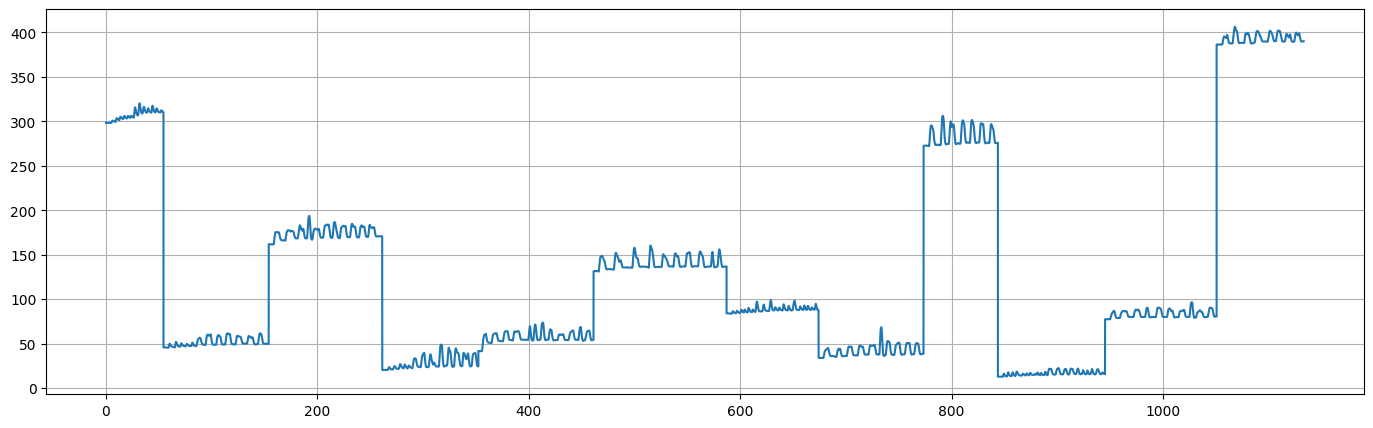

In [32]:
df = joinTables(normalized)
df.to_csv('../DataBase.csv', index=None)
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.grid()

# OBTENDO A VARIAVEL DESEJADA
Os valores de início e fim de sopro são os pontos discretizados ao longo do gráfico, o objetivo do modelo é encontrar o momento que iniciou o sopro, e o momento que não há mais sopro

test_1.csv


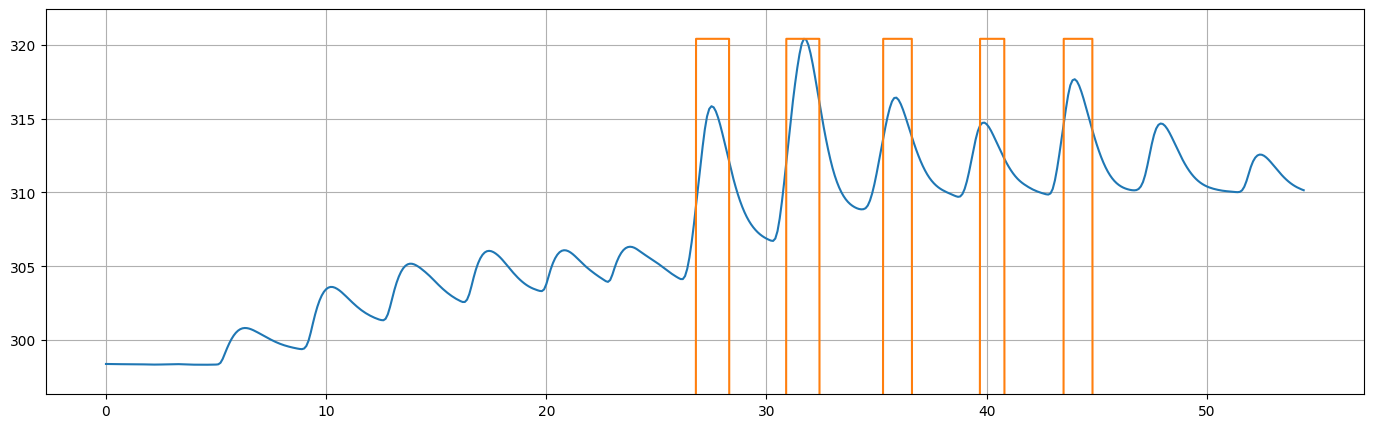

test_10.csv


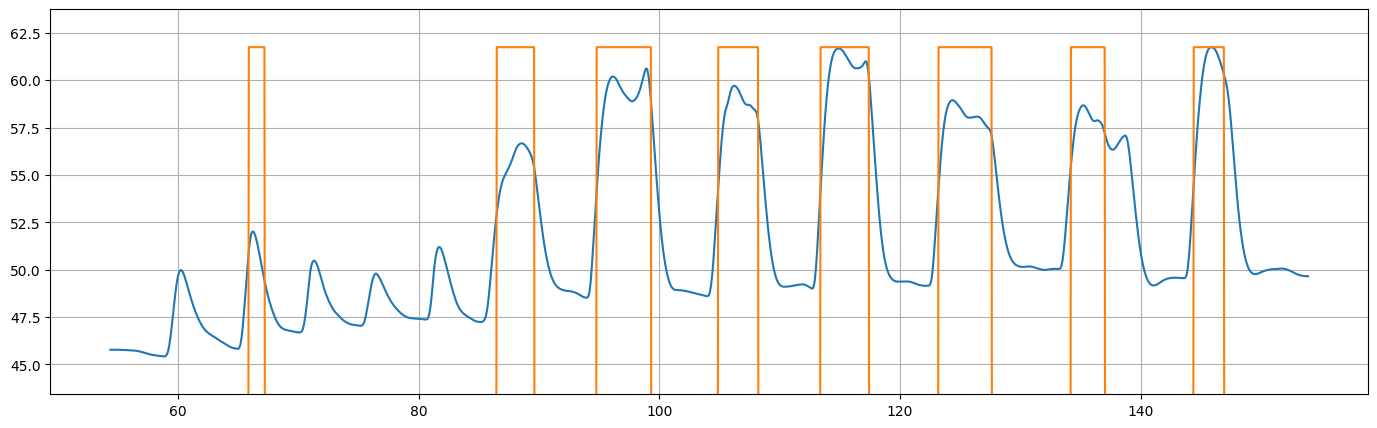

test_11.csv


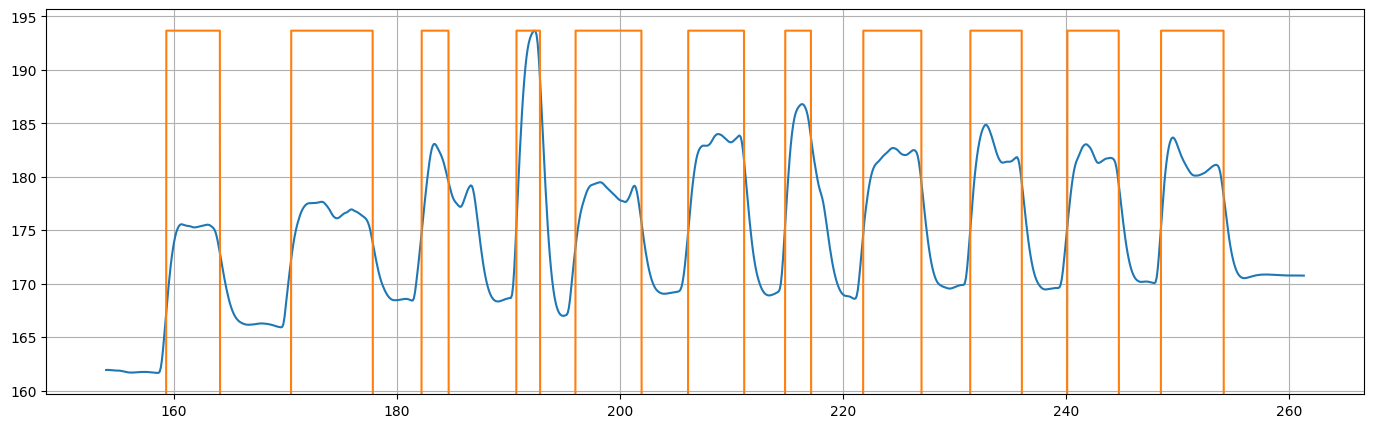

test_12.csv


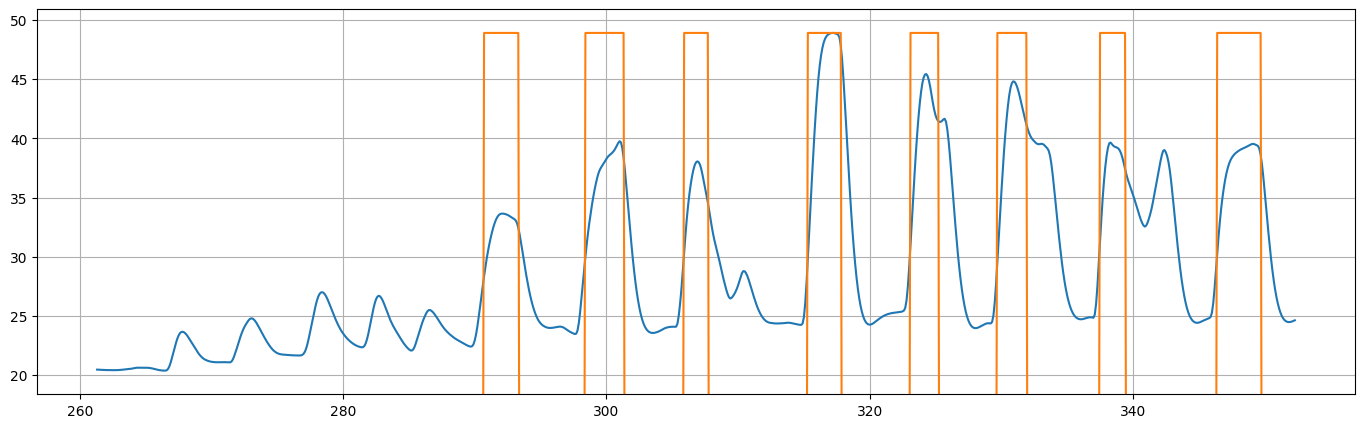

test_2.csv


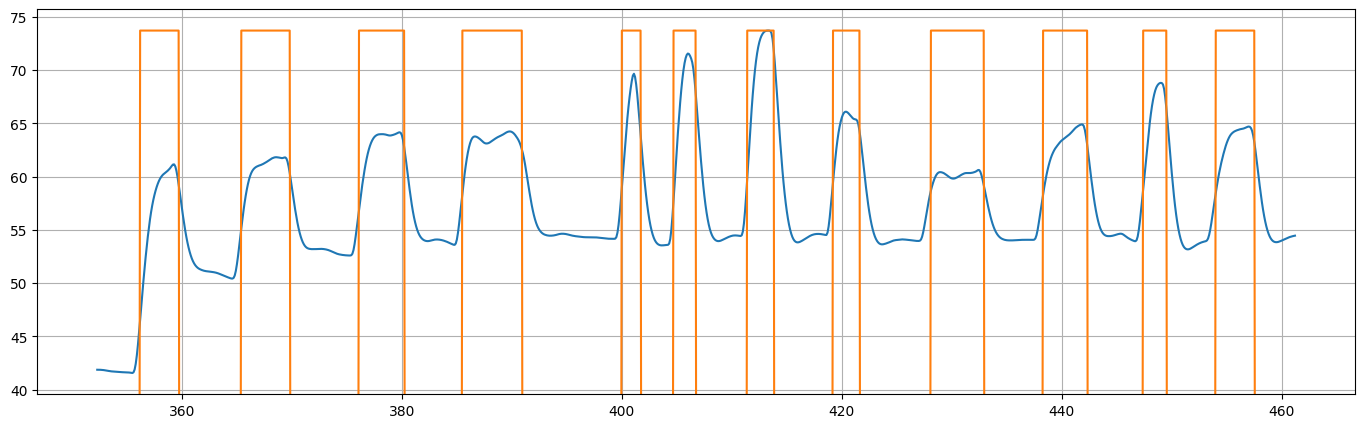

test_3.csv


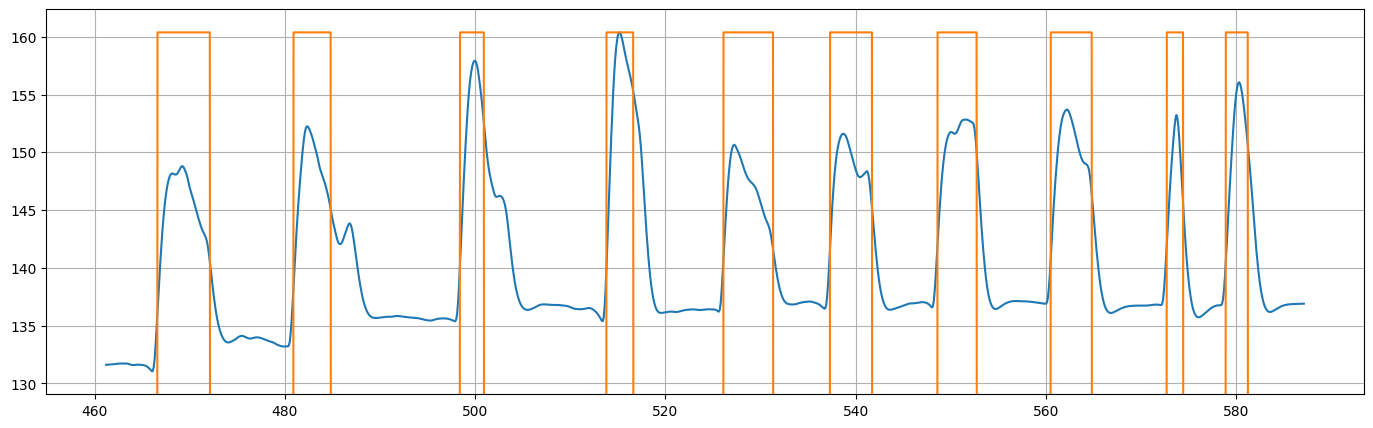

test_4.csv


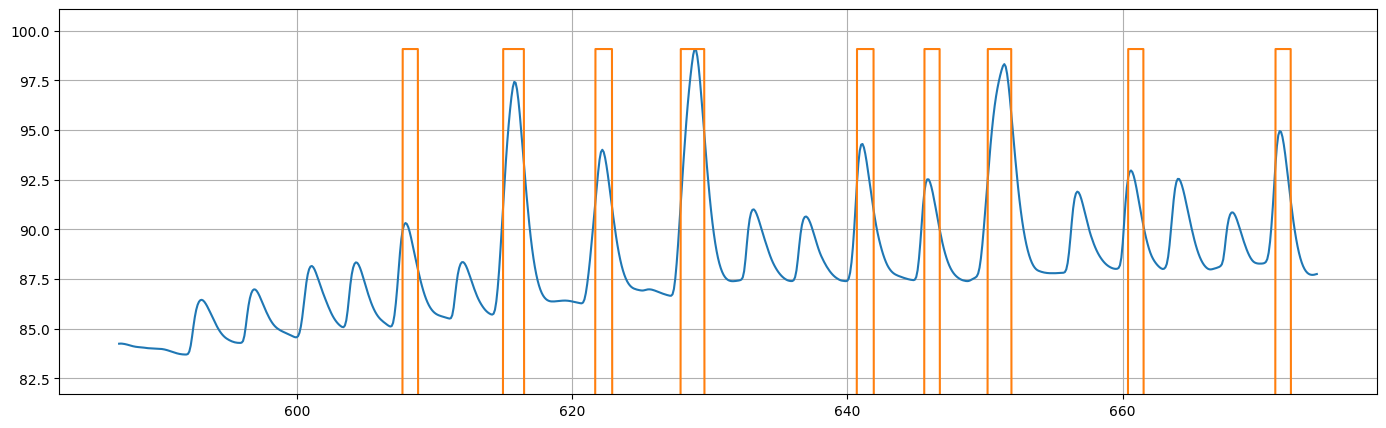

test_5.csv


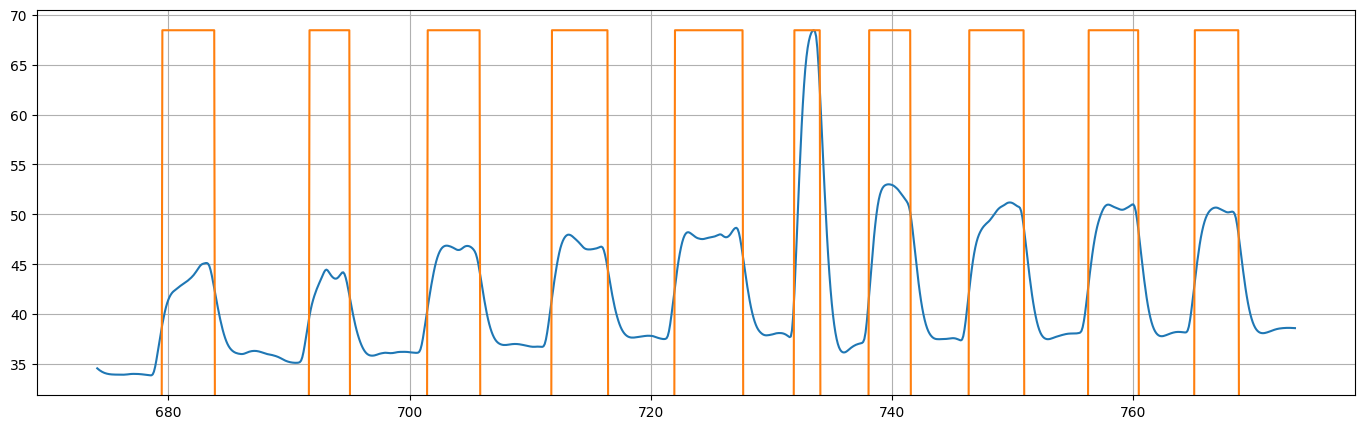

test_6.csv


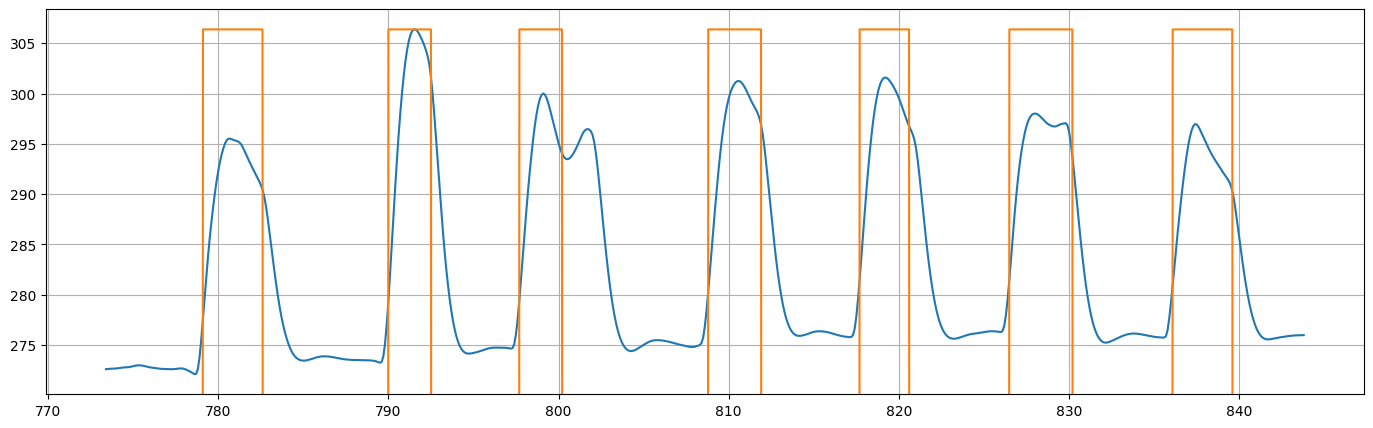

test_7.csv


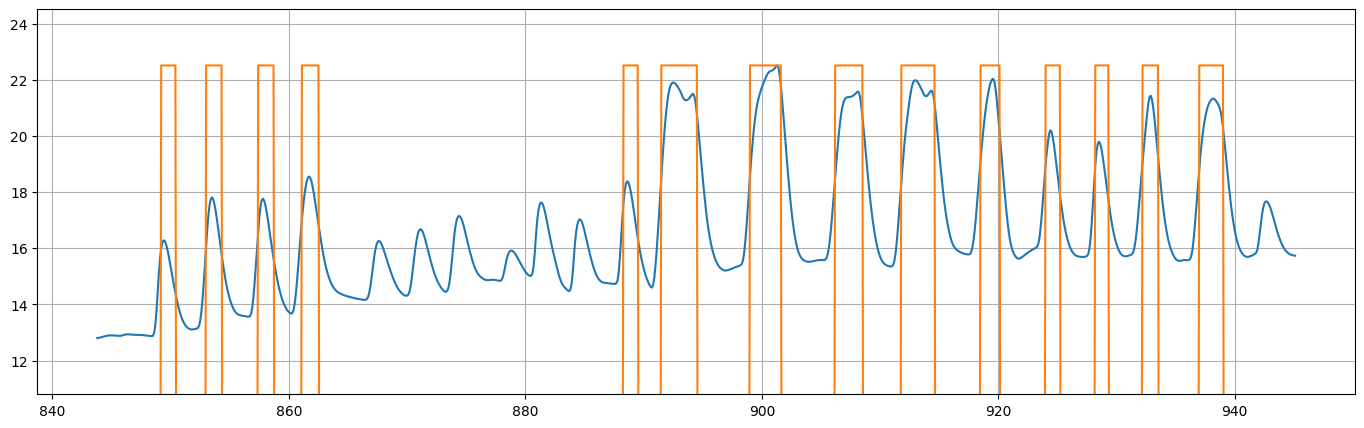

test_8.csv


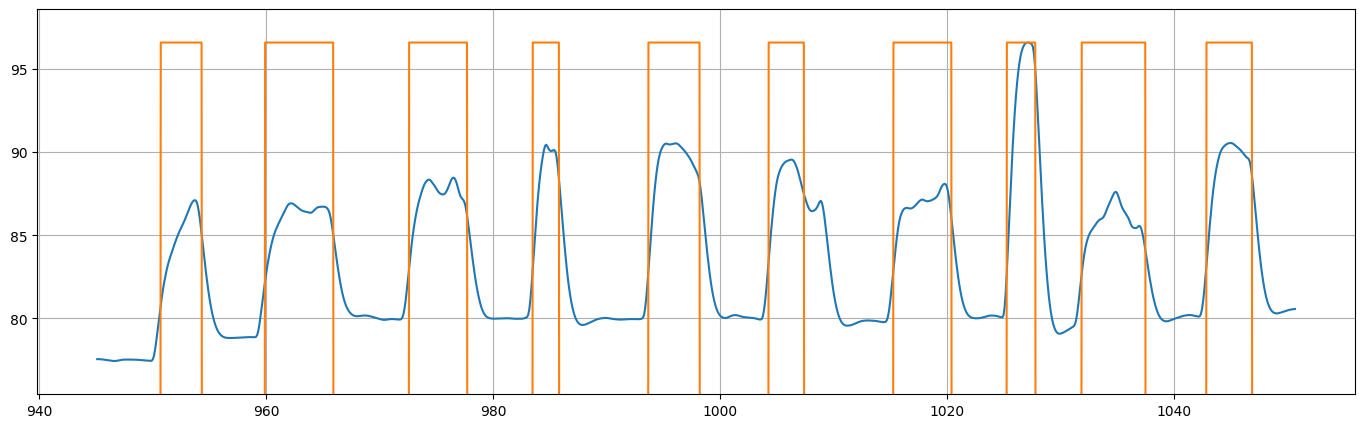

test_9.csv


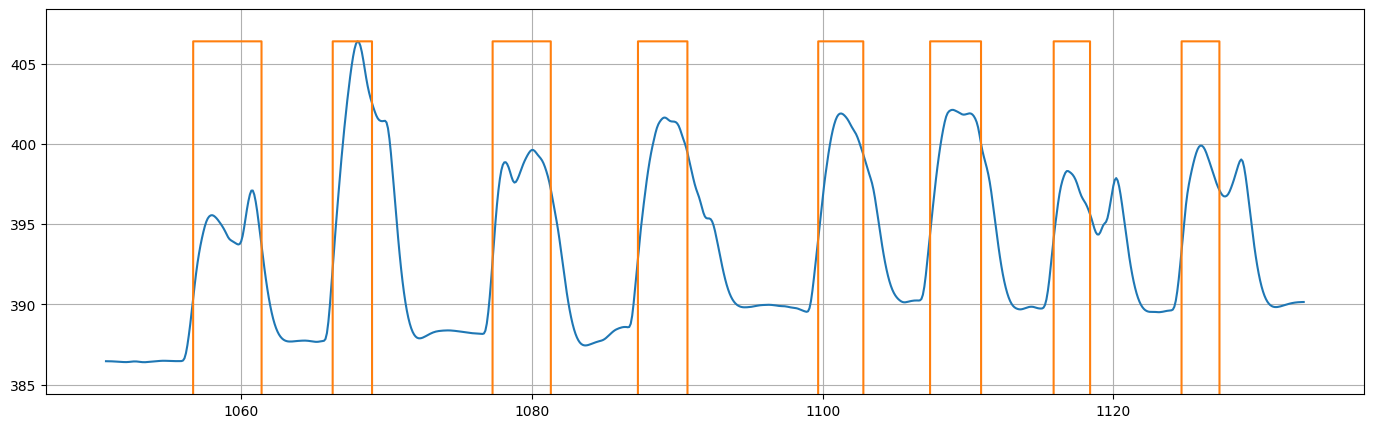

In [33]:
for name, df in normalized.items():
    plt.figure(figsize=(17, 5))
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * df.pressure.max())
    plt.ylim(df.pressure.min()-2, df.pressure.max()+2)
    print(name), plt.grid(), plt.show()